In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### GOAL:

Compare simulated 2pcf results (Illustris TNG300) to the results predicted by linear theory (Colossus).

In [2]:
# key directories
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
import illustris_python as il
from Corrfunc.theory.xi import xi
import os
import sys
sys.path.insert(0, work)
from corrfunc_ls import compute_3D_ls
from illustris_sim import IllustrisSim
import tools

#### parameters for both Colossus and Illustris

In [4]:
# redshift
redshift = 20.05
# separation values
rmin = 0.1
rmax = 50.
nbins = 20
# log bins
rbins = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)
# center of each bin (does this work like this in log?)
ravg = 0.5*(rbins[1:]+rbins[:-1])

### Colossus 2pcf

In [5]:
# set cosmology: same as used by Illustris, Planck 2015
cosmo_model = 'planck15'
cosmo = cosmology.setCosmology(cosmo_model, persistence='r')  # persistence='r' sets this to read-only

** We assume that the linear over- and underdensity field is given by a Gaussian random field which is unambiguously described by its power spectrum $P(k)$.

In [6]:
# matter power spectrum
k = np.logspace(-5.0, 2.0, 500)
Pk = cosmo.matterPowerSpectrum(k)  # defaults to the approximation of Eisenstein & Hu 1998

In [7]:
# 2-pt. matter-matter correlation function is an integral over the power spectrum:
xi_col = cosmo.correlationFunction(ravg, z=redshift)

Text(0.5, 1.0, 'Colossus 2pcf')

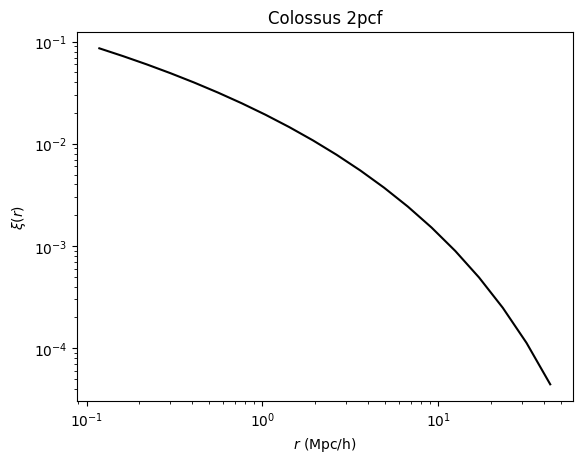

In [8]:
fig, ax = plt.subplots()
ax.plot(ravg, xi_col, 'k-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title('Colossus 2pcf')

### Illustris 2pcf

In [9]:
ilsim = IllustrisSim('TNG300-3')
ilsim.set_snapshot(redshift=redshift)
ilsim.load_dm_pos()
dm_pos = ilsim.dm_pos.value

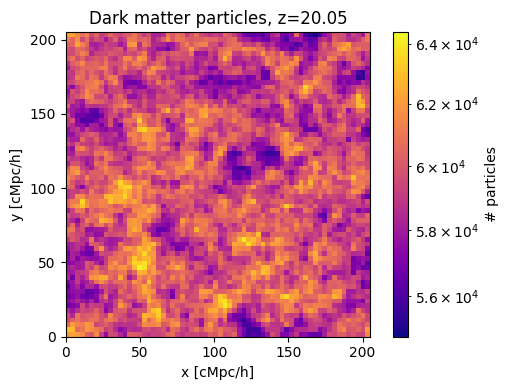

In [10]:
fig, ax = plt.subplots(figsize=(5.5,4))
_, _, _, im = ax.hist2d(dm_pos[:,0], dm_pos[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,205])
ax.set_ylim([0,205])
ticks = np.linspace(0, 200, 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
fig.colorbar(im, ax=ax, label='# particles')
ax.set_title(f'Dark matter particles, z={redshift}')
fig.tight_layout()

In [11]:
# subsample 1/100th for quicker computation
dm_subsample = tools.get_subsample(dm_pos, nx=100)

drawing 2441406 random particles...


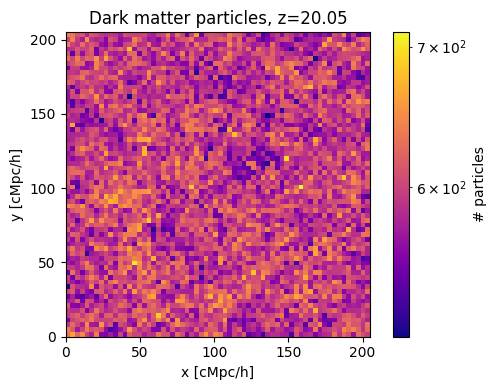

In [12]:
fig, ax = plt.subplots(figsize=(5.5,4))
_, _, _, im = ax.hist2d(dm_subsample[:,0], dm_subsample[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,205])
ax.set_ylim([0,205])
ticks = np.linspace(0, 200, 5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
fig.colorbar(im, ax=ax, label='# particles')
ax.set_title(f'Dark matter particles, z={redshift}')
fig.tight_layout()

In [13]:
%%time
# compute 3D 2pcf
randmult = 3
ravg, xi = compute_3D_ls(dm_subsample, randmult, rmin, rmax, nbins, nthreads=24)

CPU times: user 1h 13min 49s, sys: 705 ms, total: 1h 13min 49s
Wall time: 3min 6s


In [15]:
xi_il = xi

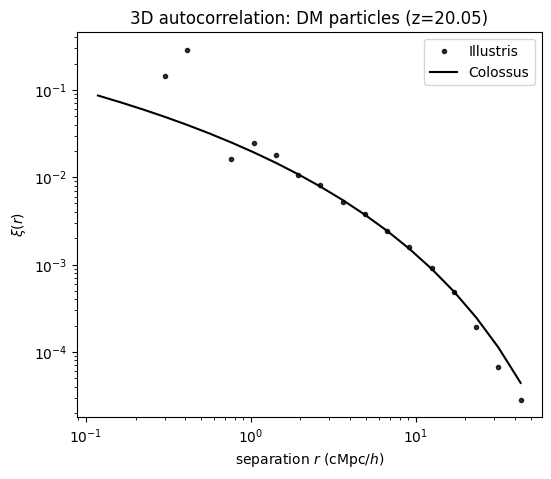

In [17]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(ravg, xi_il, color='k', marker='.', ls='None', alpha=0.8, label='Illustris')
ax.plot(ravg, xi_col, color='k', label='Colossus')

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((1e-3,1e2))
ax.set_xlabel(r'separation $r$ (cMpc/$h$)')
ax.set_ylabel(r'$\xi (r)$')
ax.set_title(f'3D autocorrelation: DM particles (z={ilsim.redshift})')
ax.legend()

### try a few different redshifts...

In [15]:
# redshifts
zs = [20.05, 10., 5., 2., 0.]

In [16]:
def compare_2pcf_il_col(z, rmin=0.1, rmax=50., nbins=20, cosmo=cosmo,
                        basepath='/scratch/08811/aew492/TNG300-3/output', nx=50, nthreads=12):
    redshift, snapshot = z
    # separation bins
    rbins = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)  # log scale
    ravg = [(rbins[i+1]+rbins[i])/2 for i in range(nbins)]  # bin centers
    # Colossus 2pcf, from input cosmology
    xi_col = cosmo.correlationFunction(ravg, z=redshift)
    # Illustris
    dm_pos = il.snapshot.loadSubset(basepath, snapshot, 'dm', ['Coordinates'])
    # convert from kpc -> Mpc
    dm_pos /= 1000
    # subsample for quicker computation
    dm_subsample = get_subsample(dm_pos, nx=nx)
    # parameters for Corrfunc
    x, y, z = dm_subsample.T
    boxsize = float(round(max(x)))
    print(boxsize)
    xi_il = xi(boxsize, nthreads, rbins, x, y, z)
    return dict(xi_col=xi_col, xi_il=xi_il, ravg=ravg, redshift=redshift)

In [17]:
%%time
redshifts = np.empty(len(zs))
xi_cols = []
xi_ils = []
for i, z in enumerate(zs):
    print(z)
    result = compare_2pcf_il_col(z, nx=100)
    redshifts[i] = result['redshift']
    xi_cols.append(result['xi_col'])
    xi_ils.append(result['xi_il'])

(20.05, 0)
drawing 2441406 random particles...
205.0
(10.0, 4)
drawing 2441406 random particles...
205.0
(0.0, 99)
drawing 2441406 random particles...
205.0
CPU times: user 18min 13s, sys: 7.92 s, total: 18min 21s
Wall time: 2min 25s


In [20]:
min(np.array(zs)[:,0])

0.0

In [30]:
# color map
cmap = mpl.colormaps['cool']
norm = mpl.colors.Normalize(vmin=min(np.array(zs)[:,0]), vmax=max(np.array(zs)[:,0]))
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

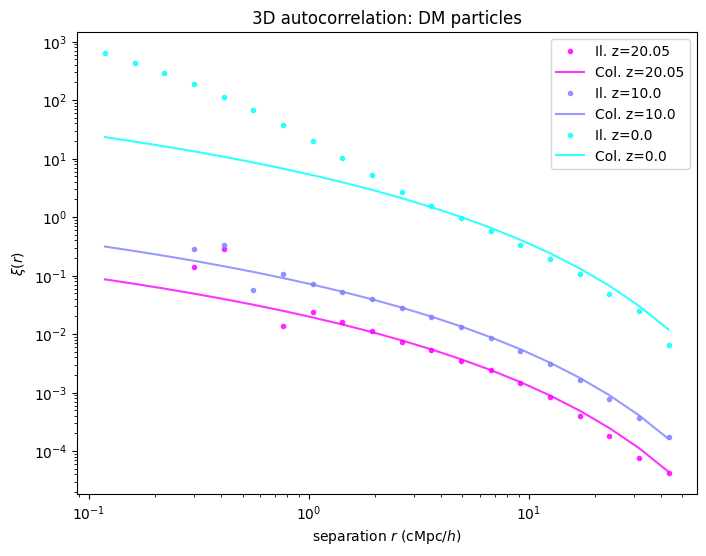

In [31]:
fig, ax = plt.subplots(figsize=(8,6))

for i, redshift in enumerate(redshifts):
    ax.plot(ravg, xi_ils[i]['xi'], c=smap.to_rgba(redshift), marker='.', ls='None', alpha=0.8, label=f'Il. z={redshift}')
    ax.plot(ravg, xi_cols[i], c=smap.to_rgba(redshift), alpha=0.8, label=f'Col. z={redshift}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (cMpc/$h$)')
ax.set_ylabel(r'$\xi (r)$')
ax.set_title(r'3D autocorrelation: DM particles')
ax.legend()